In [ ]:
from pycaret.classification import ClassificationExperiment
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from mlflow.models.signature import infer_signature
import mlflow
import pandas as pd

mlflow.set_tracking_uri("http://127.0.0.1:5500")

base_train = catalog.load('base_train')
base_test = catalog.load('base_test')

# base_train = pd.read_parquet('/Users/luiz/Study/eng-ml/kobe-bryant/data/processed/base_train.parquet')
# base_test = pd.read_parquet('/Users/luiz/Study/eng-ml/kobe-bryant/data/processed/base_test.parquet')

In [ ]:
exp = ClassificationExperiment()

exp.setup(
    data=base_train,
    test_data=base_test,
    target='shot_made_flag',
    session_id=42,
    normalize=True,
    normalize_method='robust',
    log_experiment=True,
    experiment_name='kobe'
)

# Treinar o modelo de regressão logística
log_reg_model = exp.create_model('lr')
log_reg_model_tuned_model = exp.tune_model(log_reg_model, n_iter=100, optimize='F1')

,Description,Value
0,Session id,42
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5835,0.6121,0.5052,0.5716,0.5364,0.1609,0.1619
1,0.5866,0.6068,0.5310,0.5716,0.5506,0.1688,0.1692
2,0.5786,0.6027,0.5006,0.5664,0.5315,0.1512,0.1521
3,0.5773,0.5887,0.4968,0.5653,0.5288,0.1485,0.1495
4,0.5841,0.6095,0.4761,0.5784,0.5223,0.1601,0.1625
5,0.5724,0.5982,0.4903,0.5596,0.5227,0.1385,0.1395
6,0.5527,0.5720,0.4632,0.5366,0.4972,0.0982,0.0991
7,0.6081,0.6129,0.5135,0.6058,0.5559,0.2095,0.2118
8,0.5795,0.6005,0.4948,0.5682,0.5290,0.1525,0.1537


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5860,0.6121,0.5672,0.5657,0.5665,0.1702,0.1702
1,0.5816,0.6068,0.5775,0.5594,0.5683,0.1627,0.1628
2,0.5773,0.6026,0.5600,0.5571,0.5586,0.1531,0.1531
3,0.5650,0.5886,0.5394,0.5450,0.5422,0.1279,0.1279
4,0.5866,0.6095,0.5303,0.5724,0.5506,0.1688,0.1693
5,0.5693,0.5981,0.5316,0.5508,0.5410,0.1356,0.1357
6,0.5551,0.5720,0.5123,0.5358,0.5237,0.1068,0.1069
7,0.6014,0.6130,0.5613,0.5863,0.5735,0.1996,0.1998
8,0.5721,0.6005,0.5556,0.5513,0.5534,0.1428,0.1428


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [4]:
# Avaliar o modelo no conjunto de teste
predictions = exp.predict_model(log_reg_model_tuned_model, data=base_test)

# Definir um exemplo de entrada para a assinatura do modelo
input_example = base_test.drop(columns=['shot_made_flag']).head()
signature = infer_signature(input_example, predictions[['prediction_label']])

# # Calcular métricas manualmente
y_true = base_test['shot_made_flag']
y_pred = predictions['prediction_label']
y_pred_proba = predictions['prediction_score']  # Probabilidades para log_loss

metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred),
    'recall': recall_score(y_true, y_pred),
    'f1': f1_score(y_true, y_pred),
    'log_loss': log_loss(y_true, y_pred_proba)
}

metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5682,0.5956,0.5250,0.5500,0.5372,0.1328,0.1330


{'accuracy': 0.5681538082326842,
 'precision': 0.550027041644132,
 'recall': 0.5250387196695921,
 'f1': 0.5372424722662441,
 'log_loss': 0.7090657214805237}

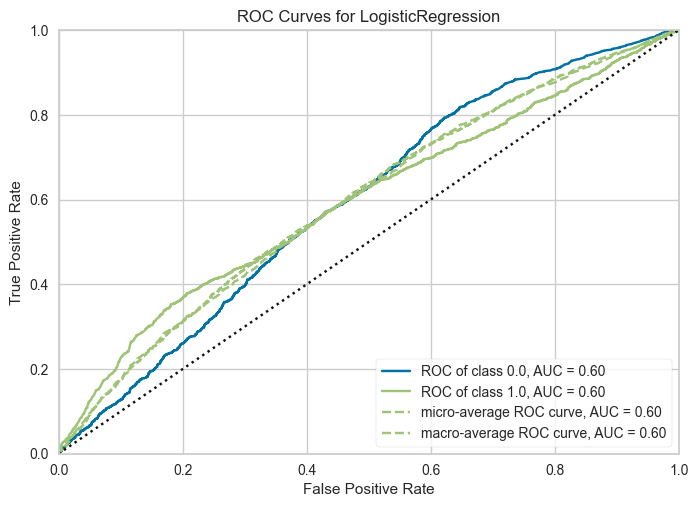

In [5]:
ret = exp.plot_model(log_reg_model_tuned_model, plot='auc')

In [ ]:
# Logar métricas calculadas
mlflow.sklearn.log_model(
    sk_model=log_reg_model_tuned_model,
    artifact_path='log_reg_model_tuned_model',
    signature=signature,
    input_example=input_example
)
mlflow.log_metrics(metrics)

In [ ]:
exp.evaluate_model(log_reg_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…